In [1]:
from neo.core import SpikeTrain
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import rand_score
from statannotations.Annotator import Annotator
from tqdm import tqdm
import elephant as eph
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import quantities as q
import seaborn as sns
import time

import sys
sys.path.append("..")
from utils import *

%config Completer.use_jedi = False

if not os.path.exists('__datacache__'):
    os.makedirs('__datacache__')
if not os.path.exists('AnalysedData'):
    os.makedirs('AnalysedData')

recalculate = False

In [2]:
def get_LN_data(mat_no,odor_no,replicate=None,time=None):
    r = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    if replicate is None:
        for i in filter(lambda v: ".npy" in v and f"{mat_no}_{odor_no}" in v,os.listdir("__datacache__")):
            temp = np.load(f"__datacache__/{i}").T
            spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
            spike_times= [np.array([0.0]+list(np.linspace(0,12.998,12999)[k>0])) for k in spikes]
            if time is not None:
                spike_times = [k[k<=time] for k in spike_times]
            event = [SpikeTrain(k*q.s,t_start=0.*q.s,t_stop=13*q.s) for k in spike_times]
            bst = eph.conversion.BinnedSpikeTrain(event,bin_size=50*q.ms)
            pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
            r.append(pearson_correlation[:,order][order,:])
    else:
        temp = np.load(f"__datacache__/data_{mat_no}_{odor_no}_{replicate}.npy").T
        spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
        spike_times= [np.array([0.0]+list(np.linspace(0,12.998,12999)[k>0])) for k in spikes]
        if time is not None:
            spike_times = [k[k<=time] for k in spike_times]
        event = [SpikeTrain(k*q.s,t_stop=13*q.s) for k in spike_times]
        bst = eph.conversion.BinnedSpikeTrain(event,bin_size=50*q.ms)
        pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
        r.append(pearson_correlation[:,order][order,:])
    return np.nan_to_num(np.array(r)),mat[:,order][order,:],module[order],order


In [3]:
if recalculate:
    clean_data_cache()
    for switch_prob in np.arange(0.0,1,0.1):
        fetch_data(switch_prob)
        results = []
        for time in tqdm(np.arange(0.5,13.5,0.5)):
            for i in range(1,11):
                for j in [13674, 59428, 72957, 84932, 85036]:
                    LN_correlations,mat,module,order = get_LN_data(i,j,time=time)
                    for k in range(10):
                        correlation = np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat.flatten())[0,1]
                        random_shuffles = [np.random.choice(np.arange(30),size=30,replace=False) for x in range(1000)]
                        shuffled = np.mean([np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat[:,order][order,:].flatten())[0,1] for order in random_shuffles])
                        results.append((time,correlation,shuffled))
        results=np.real(np.array(results))
        results = pd.DataFrame(results,columns=["Time","Original","Shuffled"])
        results.to_csv(f"AnalysedData/LNCorrelationTimeseries_0_{int(switch_prob*10)}.csv")
        results = []
        for time in tqdm(np.arange(0.5,13.5,0.5)):
            for i in tqdm(range(1,11)):
                for j in [13674, 59428, 72957, 84932, 85036]:
                    LN_correlations,mat,module,order = get_LN_data(i,j,time=time)
                    for k in range(10):
                        cluster_model = KMeans(n_clusters=int(np.max(module)))
                        cluster_model.fit((1-LN_correlations[k])/2)
                        f_correctpairs = rand_score(cluster_model.labels_,np.int32(module-1))
                        random_clustering = [np.random.choice(np.arange(4),size=30) for x in range(1000)]
                        shuffled = np.mean([rand_score(cluster_model.labels_,cluster) for cluster in random_clustering])
                        results.append((time,f_correctpairs,shuffled))
        results = np.real(np.array(results))
        results = pd.DataFrame(results,columns=["Time","Newman","Random"])
        results.to_csv(f"AnalysedData/LNReconstructionTimeseries_0_{int(switch_prob*10)}.csv")
        clean_data_cache()

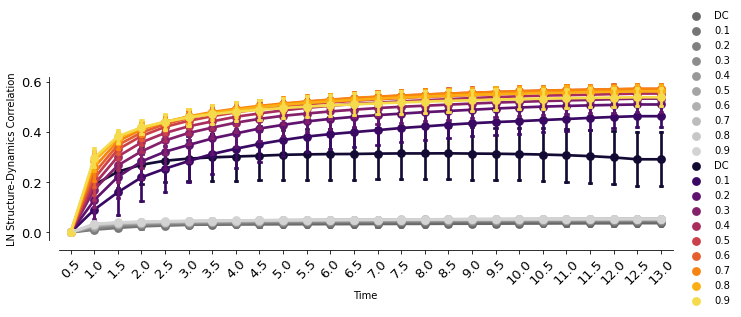

In [4]:
df = pd.DataFrame()
for i in filter(lambda v: "LNCorrelationTimeseries_" in v,os.listdir('AnalysedData/')):
    temp = pd.read_csv(f"AnalysedData/{i}",index_col=0)
    temp.fillna(0,inplace=True)
    if int(i.split('_')[2][:-4])/10 != 0.0:
        temp['Intermittency'] = "{:0.1f}".format(int(i.split('_')[2][:-4])/10)
    else:
        temp['Intermittency'] = "DC"
    df = pd.concat((df,temp))
plt.figure(figsize=(11,3))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 

ax1 = sns.pointplot(x='Time',y='Shuffled', data=df,
              palette='blend:dimgrey,lightgrey',ci='sd',capsize=0.1, hue='Intermittency')
ax2 = sns.pointplot(x='Time',y='Original', data=df,
              palette='inferno',ci='sd',capsize=0.1, hue='Intermittency')
sns.despine(offset=10, trim=False)
ax1.legend(bbox_to_anchor=(1.1, 0.5),borderaxespad=0.,frameon=False,loc='center right')
ax2.legend(bbox_to_anchor=(1.1, 0.5),borderaxespad=0.,frameon=False,loc='center right')
plt.xticks(rotation=45)
plt.ylabel("LN Structure-Dynamics Correlation")
plt.savefig(f"Figures/LN_Timeseries.svg")

In [5]:
if recalculate:
    relrates = pd.DataFrame(columns=["Intermittency","Relative Rate"])
    peakcorr = pd.DataFrame(columns=["Intermittency","Peak Correlation"])
    peaklatency = pd.DataFrame(columns=["Intermittency","Peak Latency"])
    for i in range(10):
        results = pd.read_csv(f"AnalysedData/LNCorrelationTimeseries_0_{i}.csv",index_col=0)
        results.fillna(0,inplace=True)
        results["Original Rate"] = np.concatenate([np.diff(results["Original"].values.reshape(26,-1),axis=0).flatten()/0.5,np.NaN*np.ones(500)])
        results["Shuffled Rate"] = np.concatenate([np.diff(results["Shuffled"].values.reshape(26,-1),axis=0).flatten()/0.5,np.NaN*np.ones(500)])
        results["Relative Rate"] = results["Original Rate"]-results["Shuffled Rate"]
        temp = results[results["Time"]==0.5]
        temp["Intermittency"] = "{:.1f}".format(i/10)
        temp = temp[["Intermittency","Relative Rate"]]
        relrates = pd.concat([relrates,temp])
        temp = pd.DataFrame()
        temp["Intermittency"] = np.repeat(["{:.1f}".format(i/10)],500)
        temp["Peak Correlation"] = results["Original"].values.reshape(26,-1).max(axis=0)
        peakcorr = pd.concat([peakcorr,temp])
        temp = pd.DataFrame()
        temp["Intermittency"] = np.repeat(["{:.1f}".format(i/10)],500)
        temp["Peak Latency"] = (results["Original"].values.reshape(26,-1).argmax(axis=0)+1)*0.5
        peaklatency = pd.concat([peaklatency,temp])
    relrates.to_csv("AnalysedData/LNRelativeRate.csv")
    peakcorr.to_csv("AnalysedData/LNPeakCorrelation.csv")
    peaklatency.to_csv("AnalysedData/LNPeakLatency.csv")
else:
    relrates = pd.read_csv("AnalysedData/LNRelativeRate.csv",index_col=0)
    peakcorr = pd.read_csv("AnalysedData/LNPeakCorrelation.csv",index_col=0)
    peaklatency = pd.read_csv("AnalysedData/LNPeakLatency.csv",index_col=0)
    relrates["Intermittency"] = relrates["Intermittency"].apply(lambda x: str(x))
    peakcorr["Intermittency"] = peakcorr["Intermittency"].apply(lambda x: str(x))
    peaklatency["Intermittency"] = peaklatency["Intermittency"].apply(lambda x: str(x))

D:\ProgramData\Anaconda3\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 0.1: Wilcoxon test (paired samples) with Bonferroni correction, P_val:3.379e-73 Stat=3.935e+03
0.0 vs. 0.4: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=6.190e+04


No handles with labels found to put in legend.


0.0 vs. 0.9: Wilcoxon test (paired samples) with Bonferroni correction, P_val:2.145e-81 Stat=6.750e+02


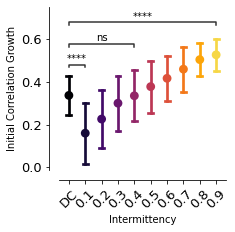

In [6]:
bpx = [('0.0','0.1'),('0.0','0.4'),('0.0','0.9')]
plt.figure(figsize=(3,3))
ax = sns.pointplot(x="Intermittency",y="Relative Rate",data=relrates,ci='sd',capsize=0.3,palette=plt.cm.inferno(np.linspace(0,1,11)))
sns.despine(offset=10, trim=False)
annotator = Annotator(ax, bpx, data=relrates, x='Intermittency',y='Relative Rate')
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
ax.legend(frameon=False)
ax.set_xticklabels(["DC", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"],rotation=45)
ax.set_ylabel("Initial Correlation Growth")
plt.savefig("Figures/LN_RelativeRate.svg")

D:\ProgramData\Anaconda3\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 0.1: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.309e-71 Stat=4.536e+03
0.6 vs. 0.9: Wilcoxon test (paired samples) with Bonferroni correction, P_val:6.726e-56 Stat=1.143e+04
0.0 vs. 0.6: Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.089e-83 Stat=1.000e+00
0.0 vs. 0.9: Wilcoxon test (paired samples) with Bonferroni correction, P_val:7.298e-83 Stat=6.100e+01


No handles with labels found to put in legend.


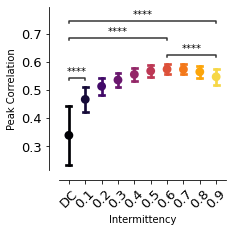

In [7]:
bpx = [('0.0','0.1'),('0.0','0.6'),('0.6','0.9'),('0.0','0.9')]
plt.figure(figsize=(3,3))
ax = sns.pointplot(x="Intermittency",y="Peak Correlation",data=peakcorr,ci='sd',capsize=0.3,palette=plt.cm.inferno(np.linspace(0,1,11)))
sns.despine(offset=10, trim=False)
annotator = Annotator(ax, bpx, data=peakcorr, x='Intermittency',y='Peak Correlation')
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
ax.legend(frameon=False)
ax.set_xticklabels(["DC", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"],rotation=45)
plt.savefig("Figures/LN_PeakCorrelation.svg")

D:\ProgramData\Anaconda3\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
No handles with labels found to put in legend.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 0.1: Wilcoxon test (paired samples) with Bonferroni correction, P_val:4.692e-79 Stat=9.685e+02
0.5 vs. 0.9: Wilcoxon test (paired samples) with Bonferroni correction, P_val:4.013e-14 Stat=2.472e+04
0.0 vs. 0.5: Wilcoxon test (paired samples) with Bonferroni correction, P_val:2.579e-81 Stat=3.645e+02
0.0 vs. 0.9: Wilcoxon test (paired samples) with Bonferroni correction, P_val:7.347e-73 Stat=3.096e+03


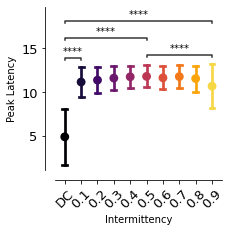

In [8]:
bpx = [('0.0','0.1'),('0.0','0.5'),('0.5','0.9'),('0.0','0.9')]
plt.figure(figsize=(3,3))
ax = sns.pointplot(x="Intermittency",y="Peak Latency",data=peaklatency,ci='sd',capsize=0.3,palette=plt.cm.inferno(np.linspace(0,1,11)))
sns.despine(offset=10, trim=False)
annotator = Annotator(ax, bpx, data=peaklatency, x='Intermittency',y='Peak Latency')
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
ax.legend(frameon=False)
ax.set_xticklabels(["DC", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"],rotation=45)
plt.savefig("Figures/LN_PeakLatency.svg")

In [9]:
def eval_module(graphno,odorno,replicateno,binsize=200,binarize=False):
    mat = np.loadtxt(f'../modules/networks/matrix_{graphno}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{graphno}_modules.csv')
    order = np.argsort(module)

    pertseed=[59428,13674,84932,72957,85036]
    
    traces = np.load(f"__datacache__/data_{graphno}_{pertseed[odorno]}_{replicateno}.npy",allow_pickle=True)
    traces = traces[:,90:]
    tt = traces
    traces = np.append(traces,np.array([np.median(traces,axis=0)]),axis=0)
    traces = np.apply_along_axis(lambda v: np.convolve(v,1000*np.ones(binsize)/binsize,)[:v.shape[0]],0,np.logical_and(traces[:-1,:]<-20,traces[1:,:]>=-20))
    tt = traces
    if binarize:
         traces = traces>0
    axs = []
    for i in np.unique(module):
        temp = np.mean(traces[:,np.arange(30)[module==i]],axis=1)
        axs.append(temp)
    axs = np.transpose(np.array(axs))
    
    return mat,module,order,axs

def get_timeseries(mat_no,odor_no,replicate,switch_prob = 0.3):
    n_n = 120
    p_n = 90
    l_n = 30
    pertseed=[59428,13674,84932,72957,85036]
    odor_no = pertseed[odor_no]

    blocktime = 12000 # in ms
    buffer = 500 # in ms
    sim_res = 1 # in ms
    min_block = 50 # in ms

    np.random.seed(mat_no+odor_no+replicate)
    if switch_prob == 0.0:
        sw_state = [1]
    else:
        sw_state = [0]

    for i in np.random.choice([0,1],p=[1-switch_prob,switch_prob],size=int(blocktime/min_block)-1):
        if i==1:
            sw_state.append(1-sw_state[-1])
        else:
            sw_state.append(sw_state[-1])
    ts = np.repeat(sw_state,int(min_block/sim_res))
    
    sim_time = blocktime + 2*buffer
    t = np.arange(0,sim_time,sim_res)
    np.random.seed(odor_no)
    setpn = np.concatenate([np.ones(9),np.zeros(81)])
    np.random.shuffle(setpn)
    ts = np.concatenate([np.zeros(int(buffer/sim_res)),ts,np.zeros(int(buffer/sim_res))])
    return setpn,t,ts

Extracting : 100%|██████████| 501/501 [07:10<00:00,  1.16it/s]


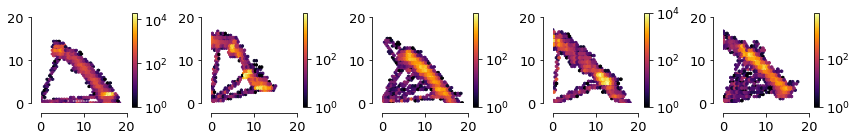

Extracting : 100%|██████████| 501/501 [07:34<00:00,  1.10it/s]


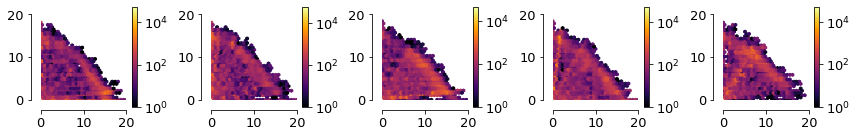

Extracting : 100%|██████████| 501/501 [05:11<00:00,  1.61it/s]


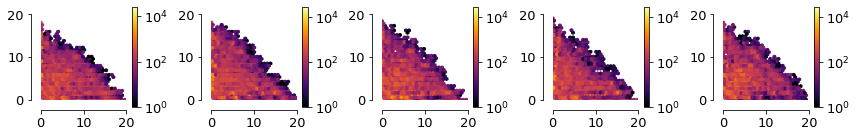

Extracting : 100%|██████████| 501/501 [06:31<00:00,  1.28it/s]


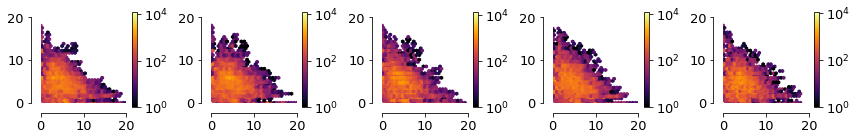

Extracting : 100%|██████████| 501/501 [07:44<00:00,  1.08it/s]


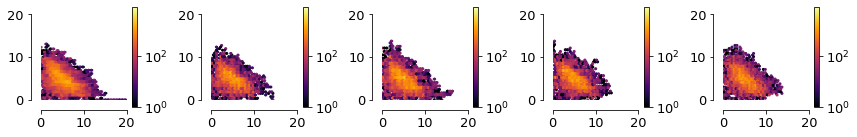

In [10]:
for switch_prob in [0.0, 0.1, 0.3, 0.6, 0.9]:
    clean_data_cache()
    fetch_data(switch_prob)
    plt.figure(figsize=(12,2))
    all_reps = []
    for i in range(1,11):
        _,_,_,axs = eval_module(2,0,i)
        _,_,ts = get_timeseries(2,0,i,switch_prob = switch_prob)
        all_reps.append(axs[:,:])
    all_reps = np.concatenate(all_reps,axis=0)
    ax1 = plt.subplot(151)
    plt.hexbin(all_reps[:,0],all_reps[:,1],gridsize=30,mincnt=1,norm=mpl.colors.LogNorm(),cmap=plt.cm.inferno)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar()
    ax1.set_xlim([0,20])
    ax1.set_ylim([0,20])
    sns.despine(ax=ax1,offset=10,trim=False)
    all_reps = []
    for i in range(1,11):
        _,_,_,axs = eval_module(2,1,i)
        _,_,ts = get_timeseries(2,1,i,switch_prob = switch_prob)
        all_reps.append(axs[:,:])
    all_reps = np.concatenate(all_reps,axis=0)
    ax2 = plt.subplot(152,sharex=ax1,sharey=ax1)
    plt.hexbin(all_reps[:,0],all_reps[:,1],gridsize=30,mincnt=1,norm=mpl.colors.LogNorm(),cmap=plt.cm.inferno)
    plt.gca().set_aspect('equal', adjustable='box')
    sns.despine(ax=ax2,offset=10,trim=False)
    plt.colorbar()
    all_reps = []
    for i in range(1,11):
        _,_,_,axs = eval_module(2,2,i)
        _,_,ts = get_timeseries(2,2,i,switch_prob = switch_prob)
        all_reps.append(axs[:,:])
    all_reps = np.concatenate(all_reps,axis=0)
    ax3 = plt.subplot(153,sharex=ax1,sharey=ax1)
    plt.hexbin(all_reps[:,0],all_reps[:,1],gridsize=30,mincnt=1,norm=mpl.colors.LogNorm(),cmap=plt.cm.inferno)
    plt.gca().set_aspect('equal', adjustable='box')
    sns.despine(ax=ax3,offset=10,trim=False)
    plt.colorbar()
    all_reps = []
    for i in range(1,11):
        _,_,_,axs = eval_module(2,3,i)
        _,_,ts = get_timeseries(2,3,i,switch_prob = switch_prob)
        all_reps.append(axs[:,:])
    all_reps = np.concatenate(all_reps,axis=0)
    ax4 = plt.subplot(154,sharex=ax1,sharey=ax1)
    plt.hexbin(all_reps[:,0],all_reps[:,1],gridsize=30,mincnt=1,norm=mpl.colors.LogNorm(),cmap=plt.cm.inferno)
    plt.gca().set_aspect('equal', adjustable='box')
    sns.despine(ax=ax4,offset=10,trim=False)
    plt.colorbar()
    all_reps = []
    for i in range(1,11):
        _,_,_,axs = eval_module(2,4,i)
        _,_,ts = get_timeseries(2,4,i,switch_prob = switch_prob)
        all_reps.append(axs[:,:])
    all_reps = np.concatenate(all_reps,axis=0)
    ax5 = plt.subplot(155,sharex=ax1,sharey=ax1)
    plt.hexbin(all_reps[:,0],all_reps[:,1],gridsize=30,mincnt=1,norm=mpl.colors.LogNorm(),cmap=plt.cm.inferno)
    plt.gca().set_aspect('equal', adjustable='box')
    sns.despine(ax=ax5,offset=10,trim=False)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f'Figures/Odorspace_switch_prob_{switch_prob:0.1f}.svg')
    plt.show()